In [2]:
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
import seaborn as sb
import pandas as pd

%matplotlib inline

import nglview as nv

import warnings
warnings.filterwarnings('ignore')

# Process data using MDAnalysis

In [3]:
u_og =  mda.Universe("first.pdb","og.pdb")
ca_og = u_og.select_atoms("name CA")

assert ca_og.universe.trajectory.frame == 0

n_frames = ca_og.universe.trajectory.n_frames
n_atoms = ca_og.n_atoms
frame_start = 0
frame_end = n_frames

ca_og_pos = np.zeros((n_frames, 3*n_atoms))

for i,_ in enumerate(ca_og.universe.trajectory[frame_start:frame_end:1]):
    tmp = ca_og.positions.flatten()
    ca_og_pos[i,:] = tmp

In [4]:
u_mod_rt =  mda.Universe("first.pdb","fit_1_rt.pdb")
ca_rt = u_mod_rt.select_atoms("name CA")

assert ca_rt.universe.trajectory.frame == 0

n_frames = ca_rt.universe.trajectory.n_frames
n_atoms = ca_rt.n_atoms
frame_start = 0
frame_end = n_frames

ca_rt_pos = np.zeros((n_frames, 3*n_atoms))

for i,_ in enumerate(ca_rt.universe.trajectory[frame_start:frame_end:1]):
    tmp = ca_rt.positions.flatten()
    ca_rt_pos[i,:] = tmp

In [5]:
u_mod_prog =  mda.Universe("first.pdb","fit_2_p.pdb")
ca_prog = u_mod_prog.select_atoms("name CA")

assert ca_prog.universe.trajectory.frame == 0

n_frames = ca_prog.universe.trajectory.n_frames
n_atoms = ca_prog.n_atoms
frame_start = 0
frame_end = n_frames

ca_prog_pos = np.zeros((n_frames, 3*n_atoms))

for i,_ in enumerate(ca_prog.universe.trajectory[frame_start:frame_end:1]):
    tmp = ca_prog.positions.flatten()
    ca_prog_pos[i,:] = tmp

# 1. Perform PCA on original coordinates

In [6]:
def Cov(X):
    """
    Calculate the covariance matrix.
    Each feature is assumed to be in a column of X.
    So we subtract the mean of each column from each observation (each row value).
    X.mean(axis=0) estimates mean of each column of X.
    Then, the formula is
    Cov = A.T @ A / (N-1)
    N-1 is called Bessel's correction.
    Verify the result with numpy's covariance matrix.
    """
    
    X_scaled = X - X.mean(axis=0) 
    cov = X_scaled.transpose() @ X_scaled / (X_scaled.shape[0] - 1)

    np_cov = np.cov(X , rowvar = False)
    assert abs(cov - np_cov).all() < 1e-8
    assert np.shape(cov) == np.shape(np_cov)

    return cov


In [7]:
def my_pca(X, num_components = 2):
    """
    Do PCA.
    X: Numpy Array
    num_components: Number of components to project to. Default is set to 2.
    """

    X_scaled = X - X.mean(axis = 0)
    
    cov_matrix = Cov(X)
    eigvals , eigvecs = np.linalg.eig(cov_matrix)

    # Sort the eigenvalues
    sorted_index = np.argsort(eigvals)[::-1]
    sorted_eigvals = eigvals[sorted_index]

    # Sort the eigenvectors
    sorted_eigvecs = eigvecs[:,sorted_index]
    eigvec_reduced_dim = sorted_eigvecs[:,0:num_components]

    # Project data on the reduced dimensional eigenvector space
    X_projected = np.dot(eigvec_reduced_dim.transpose(), X_scaled.transpose()).transpose()

    # Make a plot for eigenvalues
    plt.plot(sorted_eigvals, 'b.')
    plt.title("Sorted Eigenvalues")
    plt.xlabel(r"$\lambda$ number")
    plt.ylabel(r"$\lambda$")
    
    print(sorted_eigvals)

    return sorted_eigvals, X_projected

[6.60517125e+01 5.97120137e+01 5.16884810e+01 2.14160824e+01
 1.99372522e+01 1.85638928e+01 9.37619263e+00 8.64234164e+00
 7.23295481e+00 4.24701932e+00 3.47993151e+00 3.31526754e+00
 2.70329360e+00 2.26603828e+00 1.64118588e+00 5.71213921e-01
 4.47229603e-01 3.67846134e-01 3.32313656e-01 2.69652045e-01
 2.48662094e-01 2.31175149e-01 1.92222649e-01 1.67959875e-01
 8.33448485e-02 7.64858849e-02 7.17164400e-02 6.18503363e-02
 6.06623168e-02 5.05087784e-02]


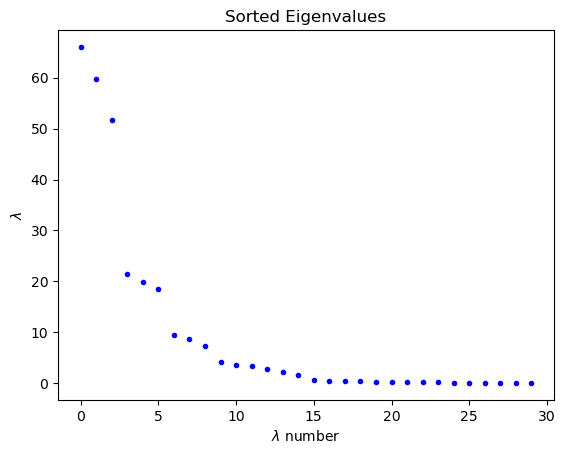

In [8]:
ca_og_eigvals, ca_og_projected = my_pca(ca_og_pos,2)

In [9]:
def scree_plot(eigvals, sklearn_PCA):

    PC_values_sklearn = np.arange(sklearn_PCA.n_components_) + 1
    
    variance_contributions = np.zeros_like(eigvals)
    for i in range(len(eigvals)):
        variance_contributions[i] = eigvals[i] / np.sum(eigvals)

    sorted_variance_contributions = np.sort(variance_contributions)
    sorted_variance_contributions = sorted_variance_contributions[::-1]
    sorted_variance_indices = variance_contributions.argsort()
    sorted_variance_indices = sorted_variance_indices[::-1]

    variance_cumsum = 0.0
    i = 0

    while variance_cumsum <= 0.95:
        variance_cumsum = variance_cumsum + sorted_variance_contributions[i]
        i += 1

    PC_values = np.arange(sorted_variance_contributions.shape[0]) + 1
    plt.title('Scree Plot')
    plt.plot(PC_values_sklearn, sklearn_PCA.explained_variance_ratio_, 'bo-', label='sklearn PCA')
    plt.plot(PC_values, sorted_variance_contributions[:], 'r.-', label='My PCA')
    plt.xlabel('Principal Component')
    plt.ylabel('Proportion of Variance Explained')
    plt.legend()
    plt.show()

    plt.title('Visualize variance change as we add diff PCs')
    plt.ylabel('Explained Variance')
    plt.xlabel('Number of components')
    plt.plot(np.cumsum(sklearn_PCA.explained_variance_ratio_), 'bo-', label='sklearn PCA')
    plt.plot(np.cumsum(sorted_variance_contributions), 'r.-', label='My PCA')
    plt.legend()
    plt.show()

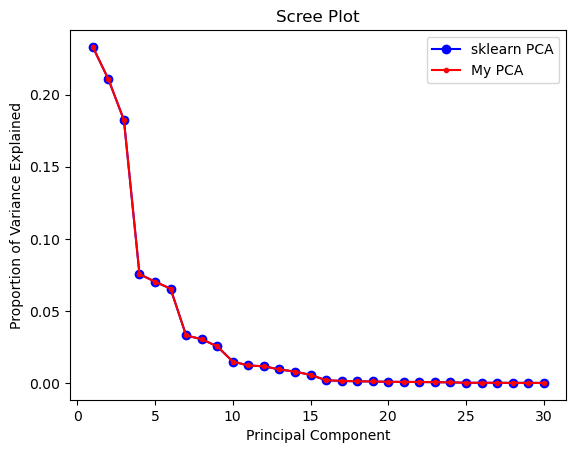

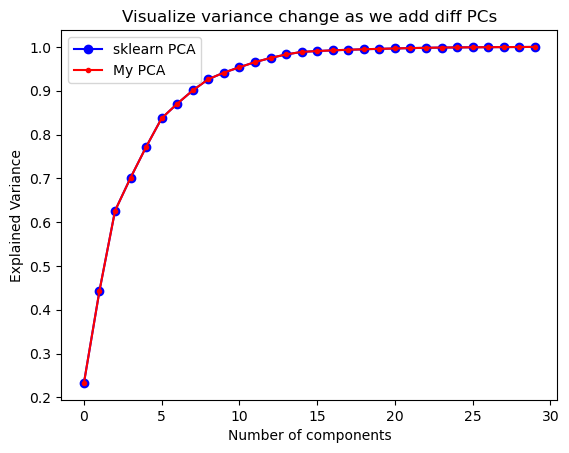

In [10]:
from sklearn.decomposition import PCA

sklearn_PCA = PCA()
sklearn_PCA.fit(ca_og_pos)
#ca_og_pca = sklearn_PCA.transform(ca_og_pos)

scree_plot(ca_og_eigvals, sklearn_PCA)

# 2. Perform PCA on modified coordinates

### There are 2 different versions of alignment I did. Both were done using Gromacs.

#### a) "-fit rot+trans" corresponds to "ca_rt" labelled variables
#### b) "-fit progressive" corresponds to "ca_prog" labelled variables

[7.89146726 4.44004027 2.41637584 1.68044761 1.4758776  1.04203688
 0.95269802 0.79624361 0.59416587 0.47729224 0.38808579 0.385304
 0.26668595 0.23095332 0.19391518 0.16258998 0.16076106 0.13414487
 0.1106222  0.09073382 0.08145589 0.06691158 0.05097544 0.04639758
 0.04096395 0.03138796 0.02329492 0.01709912 0.01339281 0.00949502]


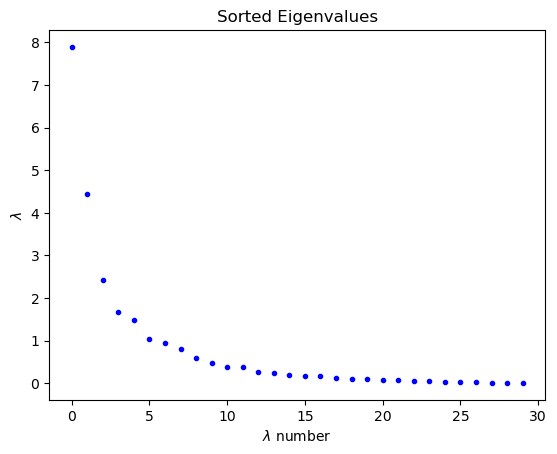

In [11]:
ca_rt_eigvals, ca_rt_projected = my_pca(ca_rt_pos,2)

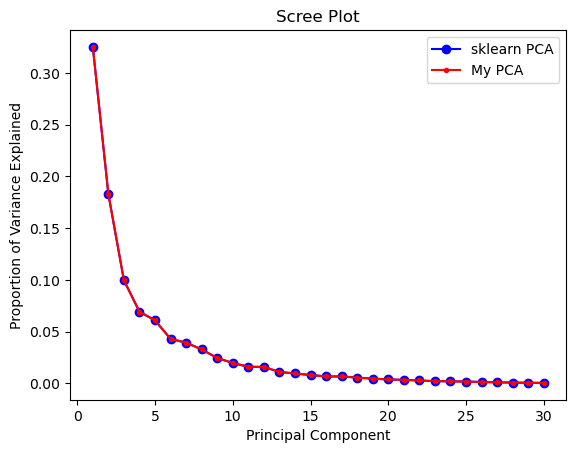

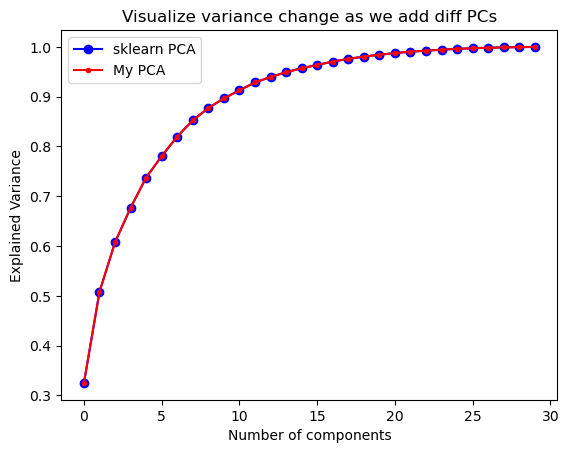

In [12]:
sklearn_PCA = PCA()
sklearn_PCA.fit(ca_rt_pos)
#ca_og_pca = sklearn_PCA.transform(ca_og_pos)

scree_plot(ca_rt_eigvals, sklearn_PCA)

#### Plotting the configurations in the space of the first 2 PCs

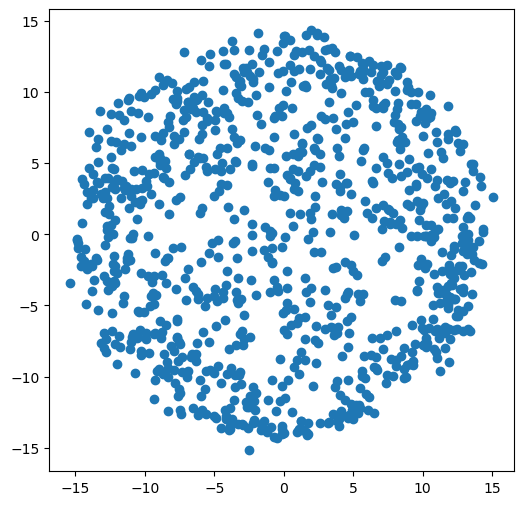

In [24]:
# plt.figure(figsize=(6,6))
# sb.scatterplot(data = ca_og_projected, s=60 , palette='icefire')
# plt.show()
plt.figure(figsize=(6,6))
plt.scatter(ca_og_projected[:,0],ca_og_projected[:,1])
plt.show()

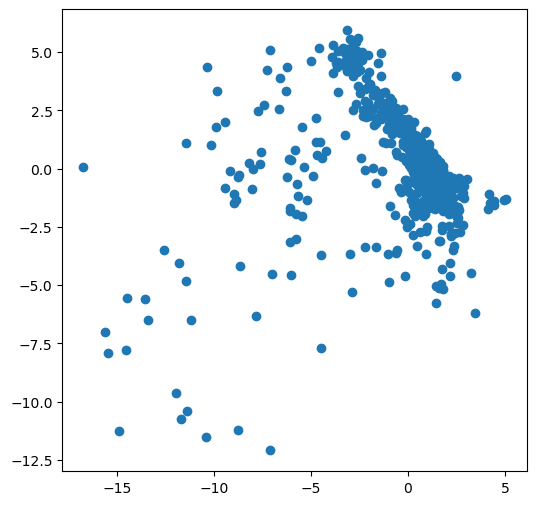

In [23]:
# plt.figure(figsize=(6,6))
# sb.scatterplot(data = ca_rt_projected, s=60 , palette='icefire')
# plt.show()
plt.figure(figsize=(6,6))
plt.scatter(ca_rt_projected[:,0],ca_rt_projected[:,1])
plt.show()

In [25]:
from MDAnalysis.analysis import pca as mda_pca
from MDAnalysis.analysis import align as mda_align

test_pc = mda_pca.PCA(u_mod_rt,select="name CA",align=True,mean=None,n_components=None).run()
test_ca = u_mod_rt.select_atoms("name CA")
test_transformed = test_pc.transform(test_ca, n_components=3)

test_df = pd.DataFrame(test_transformed,
                  columns=['PC{}'.format(i+1) for i in range(3)])
test_df['Time (ps)'] = test_df.index * u_mod_rt.trajectory.dt
test_df.head()

#g = sb.PairGrid(test_df, hue='Time (ps)',
                 #palette=sb.color_palette('Oranges_d',
                 #                          n_colors=len(test_df)))
#g.map(plt.scatter, marker='.');


test_pc1 =  test_pc.p_components[:,0]
test_trans1 = test_transformed[:,0]
test_projected = np.outer(test_trans1,test_pc1) + test_pc.mean.flatten()

test_coords = test_projected.reshape(len(test_trans1), -1, 3)

test_proj1 = mda.Merge(test_ca)
test_proj1.load_new(test_coords, order="fac")

# plt.plot(test_pc.cumulated_variance[:10],'b.')
# plt.xlabel('Principal component')
# plt.ylabel('Cumulative variance')
# plt.show()


<Universe with 10 atoms>

In [20]:
view = nv.show_mdanalysis(test_proj1.atoms)
view

NGLWidget(max_frame=999)